# Multi-layer Perceptron

In previous exercise, we implement a forward and a backward function each layer. The forward function will receive inputs, weights, and other parameters and will return both an output and a cache object storing data needed for the backward pass.After implementing a bunch of layers in this way, we will be able to easily combine them to build classifiers with different architectures.

In this layer, we build a Multi-layer Perceptron with the pre-built layers. In this exercise, we will try to learn:
- Modular design of a neiral network with seperate model creation and optimization
- Different optimization methods, including SGD, Momentum SGD, SMSProp, Adam

## 1. Basic settings

In [1]:
import time
import numpy as np
from CS231n.classifiers.fc_net import *
from CS231n.data_utils import get_CIFAR10_data
from CS231n.solver import Solver
from CS231n.gradient_check import eval_numerical_gradient
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# Optional setting
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [4]:
def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## 2. Data loading and Preprocessing

In [5]:
# Load the CIFAR10 data.
DIR_data = 'D:/CS231N_CNN/DataSet/cifar-10-batches-py/'

# the mean image has been sub-tracted
data = get_CIFAR10_data(DIR_data, num_training=49000, num_validation=1000)
# data is a dictionary:
# data = {
#        'X_train': X_train, 'y_train': y_train,
#        'X_val': X_val, 'y_val': y_val,
#        'X_test': X_test, 'y_test': y_test,
#    }

for k, v in data.items():
    print("The shape of %s is " %k,v.shape)

The shape of X_train is  (49000, 3, 32, 32)
The shape of y_train is  (49000,)
The shape of X_val is  (1000, 3, 32, 32)
The shape of y_val is  (1000,)
The shape of X_test is  (1000, 3, 32, 32)
The shape of y_test is  (1000,)


## 3. Solver

In Assignment 1, the logic for training models was coupled to the models themselves. For a new network, we have to rewrite the  training models. However, training models are unifrom framework for each network. This intefratation design is not suitbale for flexibility. So, fllowing a more modular design, for this assignment we have split the logic for training models into a separate class.

A **Solver** encapsulates all the logic necessary for training classification models:
- performs **stochastic gradient descent** using different update rules;
- accepts both training and validataion data and labels so it can **periodically check classification accuracy** on both training and validation data to watch out for overfitting.

1) When construct a **Solver** instance, we pass the **model, dataset, and various optoins** (learning rate, batch size, etc) to    the constructor. **Model** instance has the model parameters and specific loss and gradient function. These options inculde
```python
# Unpack keyword arguments
self.update_rule = kwargs.pop('update_rule', 'SGD')           # optimization method
self.optim_config = kwargs.pop('optim_config', {})            # optimization configurations, e.g. learning rate
self.lr_decay = kwargs.pop('lr_decay', 0.95)                  # learning rate dacay
self.batch_size = kwargs.pop('batch_size', 100)               # minibatch size
self.num_epochs = kwargs.pop('num_epochs', 10)                # epoch number of training

self.check_points_every = kwargs.pop('check_point_every', 1)
self.print_every = kwargs.pop('print_every', 10)
self.verbose = kwargs.pop('verbose', True)
```
In the initialization, we set up some book-keeping variables for optimization:
```python
# Set up some variables for book-keeping
self.epoch = 0
self.best_val_acc = 0        # best validation accuracy
self.best_params = {}        # optimal model parameters
self.loss_history = []       # loss of each training epoch
self.train_acc_history = []  # training accuracy of each training epoch
self.val_acc_history = []    # validation accuracy
```
2) **Model Optimization**.
   
   we will then call the **train() method** to run the optimization procedure and train the model. During the training, we calculate the training accuracy and validation accuracy at the end of each epoch.

After the train() method returns, **model.params** will contain the parameters that performed best on the validation set over the course of training. In addition, the instance variable **solver.loss_history** will contain a list of all losses encountered during training and the instance variables **solver.train_acc_history** and **solver.val_acc_history** will be lists containing the accuracies of the model on the training and validation set at each epoch.

First, we create a Two-layer Network instance and a model is obtained. In the model creation process, first, we initialize **model parameters**. Then, we calculate the **loss function** for bakward pass and inference. Third, we define the **gradient function** corresponding to each model parameter.

For example, in the **TwoLayerNet** class, we define:
```python
class TwoLayerNet(object):
    def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0):
        """
        Initialize a new network.
        """
        self.params = {}
        self.reg = reg
        self.D = input_dim
        self.M = hidden_dim
        self.C = num_classes

        w1 = weight_scale * np.random.randn(self.D, self.M)
        b1 = np.zeros(hidden_dim)
        w2 = weight_scale * np.random.randn(self.M, self.C)
        b2 = np.zeros(self.C)
        self.params.update({'W1': w1,
                            'W2': w2,
                            'b1': b1,
                            'b2': b2})
    
    def loss(self, X, y=None):
        # compute loss and gradient for minibatch of data.
        # loss
        # gradient
        return loss, grads 
```

In [6]:
# We split the logic for training models into a separate class
model = TwoLayerNet(hidden_dim=200, reg = 0.5)
solver = Solver(model, data,
              update_rule = 'SGD',
              optim_config = {
                'learning_rate': 1e-3
              },
              lr_decay = 0.95,
              num_epochs = 5,
              batch_size = 300,
              print_every = 50)
solver.train()

(Iteration "1" / "815") loss: "2.449376"
(Epoch "0" / "5") train acc: "0.185000"; val_acc: "0.180000"
(Iteration "51" / "815") loss: "2.076801"
(Iteration "101" / "815") loss: "1.838481"
(Iteration "151" / "815") loss: "1.768846"
(Epoch "1" / "5") train acc: "0.400000"; val_acc: "0.415000"
(Iteration "201" / "815") loss: "1.721031"
(Iteration "251" / "815") loss: "1.692147"
(Iteration "301" / "815") loss: "1.589437"
(Epoch "2" / "5") train acc: "0.456000"; val_acc: "0.457000"
(Iteration "351" / "815") loss: "1.745879"
(Iteration "401" / "815") loss: "1.608834"
(Iteration "451" / "815") loss: "1.717809"
(Epoch "3" / "5") train acc: "0.493000"; val_acc: "0.474000"
(Iteration "501" / "815") loss: "1.435596"
(Iteration "551" / "815") loss: "1.496823"
(Iteration "601" / "815") loss: "1.656336"
(Iteration "651" / "815") loss: "1.533426"
(Epoch "4" / "5") train acc: "0.527000"; val_acc: "0.494000"
(Iteration "701" / "815") loss: "1.453537"
(Iteration "751" / "815") loss: "1.555822"
(Iteration

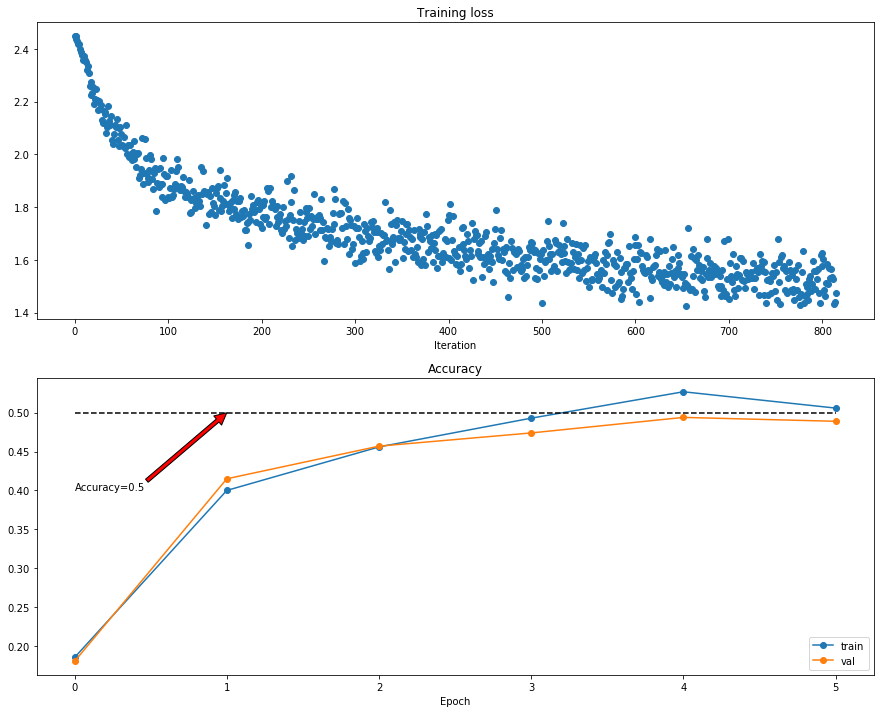

In [7]:
plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')

plt.annotate('Accuracy=0.5', xy=(1, 0.5), xytext=(0, 0.4),
        arrowprops=dict(facecolor='red'),
        )

plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

## 4. MLP layer check

In this part, we build a multi-layer perceptron with any number of hidden layers. Droupt layer and Batch-narmolization layer are optional layers. In default, the basic layer uint is Affine-Relu-Forward. Here, we pay attention to the gradient of basic layers. 

**Initialization**

In the MLP initialization step, the weights and biases are initialized.
```python
def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
                 dropout=0, use_batchnorm=False, reg=0.0, weight_scale=1e-2,dtype=np.float32, seed=None):
        """
        Initialize a new MLP

        Inputs:
         - hidden_dims: A list of integers giving the size of each hidden layer 
         - input_dim:   An integer giving the size of the input.
         - num_classes: An integer giving the number of classes to classify.
         - dropout:     Scalar between 0 and 1 giving dropout strength. 
         - use_batchnorm: Whether or not the network should use batch normalization.
         - reg: Scalar giving L2 regularization strength.
         - weight_scale: Scalar giving the standard deviation for random initialization of the weights.
         - dtype: A numpy datatype object;
         - seed: If not None, then pass this random seed to the dropout layers.This
                 will make the dropout layers deteriminstic so we can gradient check the model.
        """
        self.L = len(hidden_dims) + 1   # total layer number including the output layer
        self.N = input_dim              # number of input images
        self.C = num_classes
        dims = [self.N] + hidden_dims + [self.C] # A list containing each layer dimension
        Ws = {'W' + str(i + 1): weight_scale * np.random.randn(dims[i], dims[i+1]) for i in range(len(dims)-1)}
        b = {'b' + str(i + 1): np.zeros(dims[i+1]) for i in range(len(dims) - 1)}

        self.params.update(b)   # self.params is a dictionary containing the weigts and biases
        self.params.update(Ws) 
```
(2) **Loss**
In the forward pass, we calculate the output of each layer and store it in a dictionary hidden.
```python
hidden = {}

hidden['h0'] = X.reshape(X.shape[0], np.prod(X.shape[1:]))  #input images

for i in range(self.L):
    idx = i + 1
    
    # Naming of the variable
    w = self.params['W' + str(idx)]
    b = self.params['b' + str(idx)]
    h = hidden['h' + str(idx - 1)]                # output of the previous layer
    
    # Computing of the forward pass.
    # Special case of the last layer (output)
    if idx == self.L:
        h, cache_h = affine_forward(h, w, b)
        hidden['h' + str(idx)] = h                 # input for next layer
        hidden['cache_h' + str(idx)] = cache_h     # for gradient calculation
    # For all other layers
    else:
        h, cache_h = affine_relu_forward(h, w, b) 
        hidden['h' + str(idx)] = h                  # input for next layer
        hidden['cache_h' + str(idx)] = cache_h      # for gradient calculation
        
    scores = hidden['h' + str(self.L)]
```
(3) **Gradient**

for giadient, backprojection in the inverse order. 
```python
hidden['dh' + str(self.L)] = dscores
        
for i in range(self.L)[::-1]:
    idx = i + 1
    dh = hidden['dh' + str(idx)]
    h_cache = hidden['cache_h' + str(idx)]
    if idx == self.L:
        dh, dw, db = affine_backward(dh, h_cache)          # corresponding to affine_forward()
        hidden['dh' + str(idx - 1)] = dh
        hidden['dW' + str(idx)] = dw 
        hidden['db' + str(idx)] = db 
    else:
            dh, dw, db = affine_relu_backward(dh, h_cache) # corresponding to affine_relu_forward()
            hidden['dh' + str(idx - 1)] = dh
            hidden['dW' + str(idx)] = dw
            hidden['db' + str(idx)] = db
```

### 4.1. Initial loss and gradient check


- **Look for correct loss at chance performance.** Make sure you’re getting the loss you expect when you initialize with small parameters. It’s best to first check the data loss alone (so set regularization strength to zero). For example, for CIFAR-10 with a Softmax classifier we would expect the initial loss to be 2.302, because we expect a **diffuse probability** of 0.1 for each class (since there are 10 classes), and Softmax loss is the negative log probability of the correct class so: -ln(0.1) = 2.302. For The Weston Watkins SVM, we expect all desired margins to be violated (since all scores are approximately zero), and hence expect a loss of 9 (since margin is 1 for each wrong class). If you’re not seeing these losses there might be issue with initialization.
- As a second sanity check, increasing the regularization strength should increase the loss
- **Overfit a tiny subset of data**. Lastly and most importantly, before training on the full dataset try to train on a tiny portion (e.g. 20 examples) of your data and make sure you can achieve zero cost. For this experiment it’s also best to set regularization to zero, otherwise this can prevent you from getting zero cost. **Unless you pass this sanity check with a small dataset it is not worth proceeding to the full dataset.** Note that it may happen that you can overfit very small dataset but still have an incorrect implementation. For instance, if your datapoints’ features are random due to some bug, then it will be possible to overfit your small training set but you will never notice any generalization when you fold it your full dataset.

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [8]:
N, D, H1,H2, H3, C = 2, 15, 20, 30, 40, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size = (N,))

for reg in [0, 3.14]:
    print('Running check with reg = ' + str(reg))
    
    model = FullyConnectedNet([H1, H2, H3], 
                              input_dim=D, 
                              num_classes=C, 
                              reg = reg, 
                              weight_scale=5e-2, 
                              dtype = np.float64)
    
    loss, grads = model.loss(X, y)
    print('Initial loss: ', loss)

for name in sorted(grads):
  f = lambda _: model.loss(X, y)[0]

  grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    
  print("%s relative error: %.2e" % (name, rel_error(grad_num, grads[name])))

Running check with reg = 0
Initial loss:  2.30218577521
Running check with reg = 3.14
Initial loss:  12.339921402
W1 relative error: 2.60e-08
W2 relative error: 3.68e-03
W3 relative error: 6.00e-07
W4 relative error: 1.20e-07
b1 relative error: 8.02e-08
b2 relative error: 4.20e-01
b3 relative error: 3.83e-09
b4 relative error: 3.57e-10


As another sanity check, make sure you can **overfit a small dataset** of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to **tweak the learning rate and initialization scale**, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration "1" / "40") loss: "2.280187"
(Epoch "0" / "20") train acc: "0.360000"; val_acc: "0.132000"
(Epoch "1" / "20") train acc: "0.440000"; val_acc: "0.174000"
(Epoch "2" / "20") train acc: "0.480000"; val_acc: "0.177000"
(Epoch "3" / "20") train acc: "0.580000"; val_acc: "0.149000"
(Epoch "4" / "20") train acc: "0.620000"; val_acc: "0.168000"
(Epoch "5" / "20") train acc: "0.740000"; val_acc: "0.175000"
(Iteration "11" / "40") loss: "1.297108"
(Epoch "6" / "20") train acc: "0.680000"; val_acc: "0.152000"
(Epoch "7" / "20") train acc: "0.780000"; val_acc: "0.166000"
(Epoch "8" / "20") train acc: "0.820000"; val_acc: "0.183000"
(Epoch "9" / "20") train acc: "0.900000"; val_acc: "0.186000"
(Epoch "10" / "20") train acc: "0.940000"; val_acc: "0.187000"
(Iteration "21" / "40") loss: "0.320273"
(Epoch "11" / "20") train acc: "0.960000"; val_acc: "0.203000"
(Epoch "12" / "20") train acc: "1.000000"; val_acc: "0.187000"
(Epoch "13" / "20") train acc: "0.960000"; val_acc: "0.196000"
(Epoch

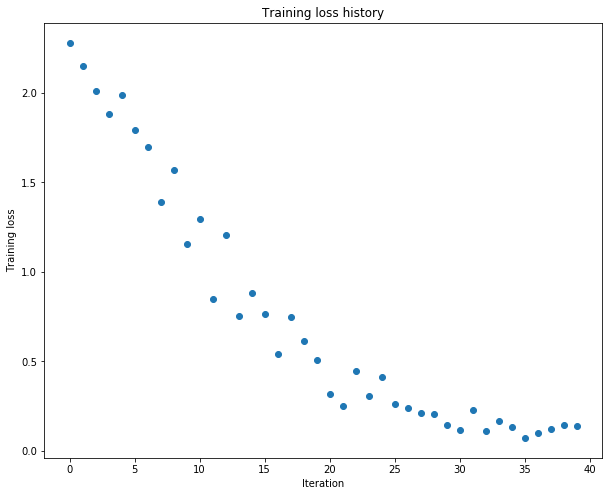

In [9]:
num_train = 50
small_data = {
'X_train': data['X_train'][:num_train],
'y_train': data['y_train'][:num_train],
'X_val': data['X_val'],
'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2

model = FullyConnectedNet([100, 100], 
                          weight_scale=weight_scale, 
                          dtype=np.float64)

solver = Solver(model, 
                small_data, 
                print_every=10, 
                num_epochs=20, 
                batch_size = 25,
                update_rule='SGD', 
                optim_config={'learning_rate': learning_rate})

solver.train()
plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

In [10]:
def run_model(weight_scale, learning_rate):
    model = FullyConnectedNet([100, 100, 100, 100], weight_scale=weight_scale, dtype=np.float64)
    
    solver = Solver(model, 
                    small_data, 
                    print_every=10, 
                    num_epochs=20, 
                    batch_size=25,
                    update_rule='SGD',
                    optim_config={
                      'learning_rate': learning_rate
                      }
                    )
    
    solver.train()
    
    return solver.train_acc_history

(Iteration "1" / "40") loss: "2.302585"
(Epoch "0" / "20") train acc: "0.120000"; val_acc: "0.105000"
(Epoch "1" / "20") train acc: "0.120000"; val_acc: "0.105000"
(Epoch "2" / "20") train acc: "0.160000"; val_acc: "0.079000"
(Epoch "3" / "20") train acc: "0.160000"; val_acc: "0.079000"
(Epoch "4" / "20") train acc: "0.160000"; val_acc: "0.079000"
(Epoch "5" / "20") train acc: "0.160000"; val_acc: "0.079000"
(Iteration "11" / "40") loss: "2.302575"
(Epoch "6" / "20") train acc: "0.160000"; val_acc: "0.079000"
(Epoch "7" / "20") train acc: "0.160000"; val_acc: "0.112000"
(Epoch "8" / "20") train acc: "0.160000"; val_acc: "0.112000"
(Epoch "9" / "20") train acc: "0.160000"; val_acc: "0.112000"
(Epoch "10" / "20") train acc: "0.160000"; val_acc: "0.112000"
(Iteration "21" / "40") loss: "2.302557"
(Epoch "11" / "20") train acc: "0.160000"; val_acc: "0.112000"
(Epoch "12" / "20") train acc: "0.160000"; val_acc: "0.112000"
(Epoch "13" / "20") train acc: "0.160000"; val_acc: "0.112000"
(Epoch

D:\CS231N_CNN\notebook\Assignment2\CS231n\layers.py:703: RuntimeWarning: divide by zero encountered in log
  loss = -np.sum(np.log(probs[np.arange(N), y])) / N


(Epoch "3" / "20") train acc: "0.100000"; val_acc: "0.102000"
(Epoch "4" / "20") train acc: "0.160000"; val_acc: "0.079000"
(Epoch "5" / "20") train acc: "0.120000"; val_acc: "0.119000"
(Iteration "11" / "40") loss: "inf"
(Epoch "6" / "20") train acc: "0.100000"; val_acc: "0.108000"


D:\CS231N_CNN\notebook\Assignment2\CS231n\classifiers\fc_net.py:312: RuntimeWarning: overflow encountered in multiply
  reg_loss += 0.5 * self.reg * np.sum(w * w)
D:\CS231N_CNN\notebook\Assignment2\CS231n\classifiers\fc_net.py:312: RuntimeWarning: invalid value encountered in double_scalars
  reg_loss += 0.5 * self.reg * np.sum(w * w)


(Epoch "7" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Epoch "8" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Epoch "9" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Epoch "10" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Iteration "21" / "40") loss: "nan"
(Epoch "11" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Epoch "12" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Epoch "13" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Epoch "14" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Epoch "15" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Iteration "31" / "40") loss: "nan"
(Epoch "16" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Epoch "17" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Epoch "18" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Epoch "19" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Epoch "20" / "20") train acc: "0.100000"; val_acc: "0.108000"
(Iteration "1" / "40") loss: "2.302585"
(Epoch "0

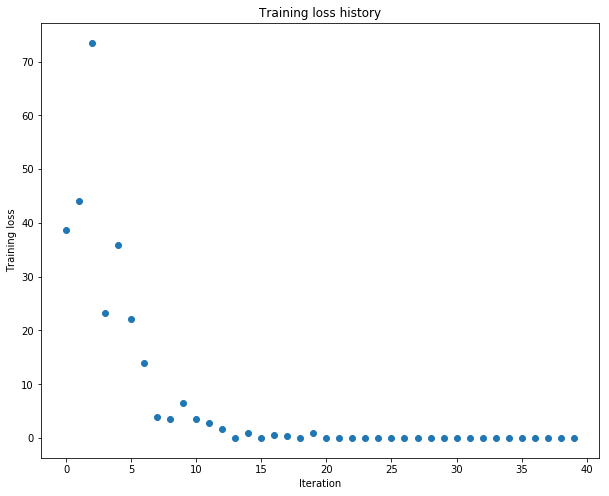

In [11]:
num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

not_reach = True

while not_reach:
    
    weight_scale = 10**(np.random.uniform(-6,-1))
    learning_rate = 10**(np.random.uniform(-4,-1))
    
    train_acc_hist = run_model(weight_scale,learning_rate)
    
    if max(train_acc_hist) == 1.0:
        not_reach = False
        lr = learning_rate
        ws = weight_scale

        
model = FullyConnectedNet([100, 100,100,100],
        weight_scale=ws, dtype=np.float64)

solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='SGD',
                optim_config={
                   'learning_rate': lr,
                   }
         )
solver.train()
    
print("Has worked with %f and %f" % (lr,ws))
plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

## 5. Update Rules

**Optimization methods**

(1) **Vanilla update**.

 The simplest form of update is to change the parameters along the negative gradient direction. Assuming a vector of parameters ${\bf{x}}$ and the gradient $d{\bf{x}}$, the simplest update has the form:
```python
# Vanilla update
x += - learning_rate * dx
```
where <font color=#ff0000>*learning_rate*</font> is a hyperparameter: a fixed constant. When evaluated on the full dataset, and when the learning rate is low enough, this is guaranteed to make non-negative progress on the loss function.

(2) **Momentum Update**.

 Another approach that almost always enjoys better converge rates on deep networks. This update can be motivated from a physical perspective of the optimization problem. In particular, the loss can be interpreted as a the height of a hilly terrain (and therefore also to the potential energy since $U = mgh$ and therefore $U \propto h$ ). Initializing the parameters with random numbers is equivalent to setting a particle with zero initial velocity at some location. The optimization process can then be seen as equivalent to the process of simulating the parameter vector (i.e. a particle) as rolling on the landscape.

Since the force on the particle is related to the gradient of potential energy (i.e. $F =  - \nabla U$), the **force** felt by the particle is precisely the (negative) **gradient** of the loss function. Moreover, $F=ma$ so the (negative) gradient is in this view proportional to the acceleration of the particle. Note that this is different from the SGD update shown above, where the gradient directly integrates the position. Instead, the physics view suggests an update in which the gradient only directly influences the velocity, which in turn has an effect on the position:
```python
# Momentum update
v = mu * v - learning_rate * dx # integrate velocity
x += v # integrate position
```

Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

(3) **Nesterov Momentum**.

 is a slightly different version of the momentum update has recently been gaining popularity. It enjoys stronger theoretical converge guarantees for convex functions and in practice it also consistenly works slightly better than standard momentum. 

The core idea behind Nesterov momentum is that when the current parameter vector is at some position **x**, then looking at the momentum update above, we know that the momentum term alone (i.e. ignoring the second term with the gradient) is about to nudge the parameter vector by **mu*v**. Therefore, if we are about to compute the gradient, we can treat the future approximate position **x + mu * v** as a “lookahead” - this is a point in the vicinity of where we are soon going to end up. Hence, it makes sense to compute the gradient at **x + mu * v** instead of at the “old/stale” position **x**.

![](momentum.PNG)

```python
x_ahead = x + mu * v
# evaluate dx_ahead (the gradient at x_ahead instead of at x)
v = mu * v - learning_rate * dx_ahead
x += v
```

However, in practice people prefer to express the update to look as similar to vanilla SGD or to the previous momentum update as possible. This is possible to achieve by manipulating the update above with a variable transform **x_ahead = x + mu * v**, and then expressing the update in terms of **x_ahead** instead of **x**. That is, **the parameter vector we are actually storing is always the ahead version**. The equations in terms of **x_ahead** (but renaming it back to **x**) then become:

```python
v_prev = v # back this up
v = mu * v - learning_rate * dx # velocity update stays the same
x += -mu * v_prev + (1 + mu) * v # position update changes form
```
**Derivation**:
$$
\begin{array}{l}
{v_{t{\rm{ + 1}}}}{\rm{ = }}\rho {v_t} - \alpha \nabla f\left( {{x_t} + \rho {v_t}} \right)\\
{x_{t + 1}} = {x_t} + {v_{t + 1}}
\end{array}
$$
Let 
$$
{{\tilde x}_t} = {x_t} + \rho {v_t}
$$

$$
\begin{align}
{v_{t{\rm{ + 1}}}} &= \rho {v_t} - \alpha \nabla f\left( {{{\tilde x}_t}} \right)\\
{{\tilde x}_{t + 1}} &= {x_{t + 1}} + \rho {v_{t + 1}}\\
 &= {x_t} + {v_{t + 1}} + \rho {v_{t + 1}}\\
 &= {{\tilde x}_t} - \rho {v_t} + {v_{t + 1}} + \rho {v_{t + 1}}\\
 &= {{\tilde x}_t} + {v_{t + 1}} + \rho \left( {{v_{t + 1}} - {v_t}} \right)
\end{align}
$$


## 5.1. SGD+Momentum

In [12]:
from CS231n.optim import SGD_momentum

N, D = 4, 5

w  = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v  = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = SGD_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print ('next_w error: ', rel_error(next_w, expected_next_w))
print ('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

**Note**

for the uniformity, the optimization parameters including the velocity introduced by the momentum are stored in **optim_config** dictionary. **For the parameters of different layer, leanring rate can be the same, but velocities are different**, so, some modifications are tuned to solver function.

First, in the class initialization stage, make a deep copy of the optim_config for each parameter:
```python
def _reset(self):
    
    # privious operations
    
    # Make a deep copy of the optim_config for each parameter
    self.optim_configs = {}
    for p in self.model.params: # generate the key 
        d = {k: v for k, v in self.optim_config.items()} # generate the values, also dictionary
        self.optim_configs[p] = d
```

Second, in the network parameters update stage:
```python
for p, w in self.model.params.items(): # p is the key
    dw = grads[p]
    config = self.optim_configs[p]     # get the corresponding update configure
    next_w, next_config = self.update_rule(w, dw, config)
    self.model.params[p] = next_w
    self.optim_configs[p] = next_config
```

Third, in the optimization parameters updating stage:
```python
# At the end of every epoch, increment the epoch counter and decay the learning rate.
epoch_end = (t + 1) % iterations_per_epoch == 0
if epoch_end:
    self.epoch += 1
    for p in self.optim_configs:  # p is the key
        self.optim_configs[p]['learning_rate'] *= self.lr_decay
```

running with  SGD
(Iteration "1" / "400") loss: "2.661065"
(Epoch "0" / "5") train acc: "0.119000"; val_acc: "0.117000"
(Iteration "11" / "400") loss: "2.291450"
(Iteration "21" / "400") loss: "2.157519"
(Iteration "31" / "400") loss: "2.052785"
(Iteration "41" / "400") loss: "2.158824"
(Iteration "51" / "400") loss: "2.110893"
(Iteration "61" / "400") loss: "1.835868"
(Iteration "71" / "400") loss: "1.999132"
(Epoch "1" / "5") train acc: "0.277000"; val_acc: "0.249000"
(Iteration "81" / "400") loss: "1.901430"
(Iteration "91" / "400") loss: "1.981766"
(Iteration "101" / "400") loss: "1.976465"
(Iteration "111" / "400") loss: "1.915233"
(Iteration "121" / "400") loss: "1.943900"
(Iteration "131" / "400") loss: "1.776804"
(Iteration "141" / "400") loss: "1.900365"
(Iteration "151" / "400") loss: "1.744885"
(Epoch "2" / "5") train acc: "0.340000"; val_acc: "0.291000"
(Iteration "161" / "400") loss: "1.846147"
(Iteration "171" / "400") loss: "1.832179"
(Iteration "181" / "400") loss: "2.0

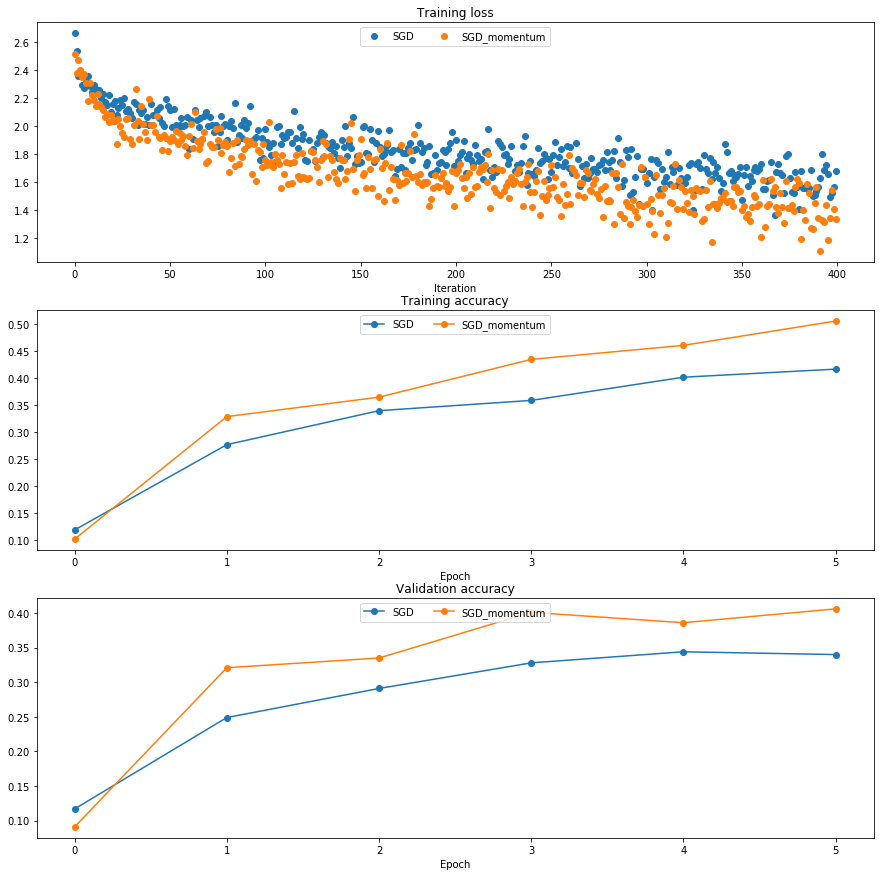

In [13]:
num_train = 8000
small_data = {
'X_train': data['X_train'][:num_train],
'y_train': data['y_train'][:num_train],
'X_val': data['X_val'],
'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['SGD', 'SGD_momentum']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                    num_epochs=5, batch_size=100,
                    update_rule=update_rule,
                    optim_config={
                      'learning_rate': 1e-2,
                    },  # for SGD_Momentum, momentum will be initialized in funtion SGD_momentum() by default 0.9
                    verbose=True)
    solvers[update_rule] = solver
    solver.train()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
    
plt.gcf().set_size_inches(15, 15)
plt.show()

## 5.2. RMSPop and Adam

- **RMSprop**. RMSprop is a very effective, but currently unpublished adaptive learning rate method. Amusingly, everyone who uses this method in their work currently cites slide 29 of Lecture 6 of Geoff Hinton’s Coursera class. The RMSProp update adjusts the Adagrad method in a very simple way in an attempt to reduce its aggressive, monotonically decreasing learning rate. In particular, it uses a moving average of squared gradients instead, giving:
```python
cache = decay_rate * cache + (1 - decay_rate) * dx**2
x += - learning_rate * dx / (np.sqrt(cache) + eps)
```
Here, **decay_rate** is a hyperparameter and typical values are [0.9, 0.99, 0.999]. Notice that the **x+=** update is identical to Adagrad, but the **cache** variable is a “leaky”. Hence, RMSProp still modulates the learning rate of each weight based on the magnitudes of its gradients, which has a beneficial equalizing effect, but unlike Adagrad the updates do not get monotonically smaller.

- **Adam**. Adam is a recently proposed update that looks a bit like RMSProp with momentum. The (simplified) update looks as follows:
```python
m = beta1*m + (1-beta1)*dx
v = beta2*v + (1-beta2)*(dx**2)
x += - learning_rate * m / (np.sqrt(v) + eps)
```
Notice that the update looks exactly as RMSProp update, except the “smooth” version of the gradient **m** is used instead of the raw (and perhaps noisy) gradient vector **dx**. Recommended values in the paper are **eps = 1e-8**, **beta1 = 0.9, beta2 = 0.999**. In practice Adam is currently recommended as the default algorithm to use, and often works slightly better than RMSProp. However, it is often also worth trying SGD+Nesterov Momentum as an alternative. The full Adam update also includes a bias correction mechanism, which compensates for the fact that in the first few time steps the vectors **m,v** are both initialized and therefore biased at zero, before they fully “warm up”. We refer the reader to the paper for the details, or the course slides where this is expanded on.

In [16]:
# Test RMSProp implementation; you should see errors less than 1e-7
from CS231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print ('next_w error: ', rel_error(expected_next_w, next_w))
print ('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.50264522989e-08
cache error:  2.64779558072e-09


In [17]:
# Test Adam implementation; you should see errors around 1e-7 or less
from CS231n.optim import Adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = Adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print( 'next_w error: ', rel_error(expected_next_w, next_w))
print( 'v error: ', rel_error(expected_v, config['v']))
print( 'm error: ', rel_error(expected_m, config['m']))

next_w error:  1.13988746733e-07
v error:  4.20831403811e-09
m error:  4.21496319311e-09


running with  Adam
(Iteration "1" / "800") loss: "2.637374"
(Epoch "0" / "10") train acc: "0.117000"; val_acc: "0.106000"
(Iteration "11" / "800") loss: "2.030634"
(Iteration "21" / "800") loss: "2.077647"
(Iteration "31" / "800") loss: "1.898023"
(Iteration "41" / "800") loss: "1.844093"
(Iteration "51" / "800") loss: "1.649338"
(Iteration "61" / "800") loss: "1.663048"
(Iteration "71" / "800") loss: "1.617584"
(Epoch "1" / "10") train acc: "0.364000"; val_acc: "0.353000"
(Iteration "81" / "800") loss: "1.640542"
(Iteration "91" / "800") loss: "1.644805"
(Iteration "101" / "800") loss: "1.566619"
(Iteration "111" / "800") loss: "1.694459"
(Iteration "121" / "800") loss: "1.542115"
(Iteration "131" / "800") loss: "1.807030"
(Iteration "141" / "800") loss: "1.589902"
(Iteration "151" / "800") loss: "1.777528"
(Epoch "2" / "10") train acc: "0.437000"; val_acc: "0.377000"
(Iteration "161" / "800") loss: "1.704158"
(Iteration "171" / "800") loss: "1.583161"
(Iteration "181" / "800") loss: 

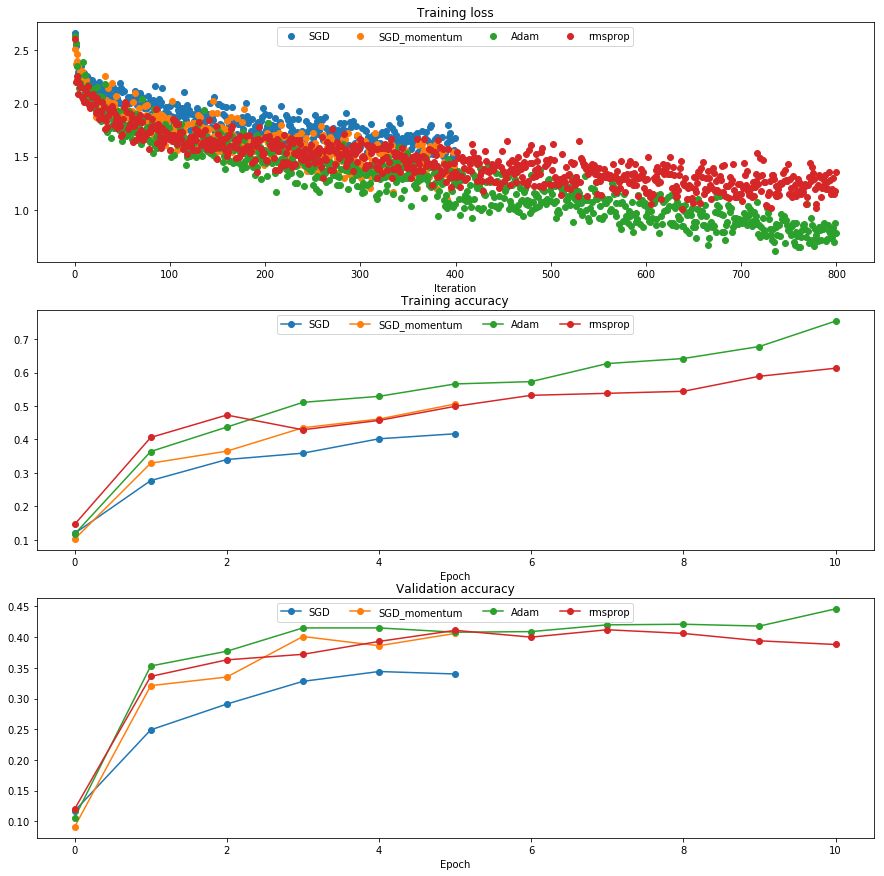

In [18]:
learning_rates = {'rmsprop': 1e-4, 'Adam': 1e-3}
for update_rule in ['Adam', 'rmsprop']:
    print('running with ', update_rule)
    model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

    solver = Solver(model, small_data,
                    num_epochs=10, batch_size=100,
                    update_rule=update_rule,
                    optim_config={
                      'learning_rate': learning_rates[update_rule]
                    },
                    verbose=True)
    solvers[update_rule] = solver
    solver.train()
    print

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in solvers.items():
    plt.subplot(3, 1, 1)
    plt.plot(solver.loss_history, 'o', label=update_rule)

    plt.subplot(3, 1, 2)
    plt.plot(solver.train_acc_history, '-o', label=update_rule)

    plt.subplot(3, 1, 3)
    plt.plot(solver.val_acc_history, '-o', label=update_rule)

for i in [1, 2, 3]:
    plt.subplot(3, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()